# Predicting a Wine’s Cultivator from its Chemical Characteristics

This dataset is a result of chemical analysis done on different wines grown in the same Italien region, but originating from 3 different cultivators. Each row contains the quantity of 13 different chemical constituents found in a wine from a particular cultivator. This model will attempt to use these measurements to predict a wine’s cultivator, answering the question: “based on the chemical composition of a wine, can its origin be determined?”

Please note no units were provideed in the dataset or website.

In [4]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(httr)
library(GGally)

In [6]:
# read data
wine_path <- 'https://raw.githubusercontent.com/JadenMajid/dsci-100-student-grades/main/wine.data'

wine_data <- read_delim(file = wine_path, delim = ",", col_names = FALSE) |>
    mutate(X1 = as_factor(X1)) |>
    select(-X14)

# column names obtained from UCI Ml website
colnames(wine_data) <- c('alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium', 'total_phenols',
                         'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
                         'hue', 'ODnum', 'proline')
# split data
split <- wine_data |>
    initial_split(prop = 0.75, strata = alcohol)

wine_training_data <- training(split)
wine_test_data <- testing(split)

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preliminary Exploratory Data Analysis

In [7]:
# mean
mean_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, mean))
mean_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.75682,2.101818,2.446591,16.90909,105.68182,2.824773,2.9690909,0.2900000,1.890227,5.573182,1.0631818,3.133636
2,12.25906,1.879434,2.267358,20.37358,95.77358,2.278302,2.0618868,0.3632075,1.616415,3.096792,1.0607547,2.757358
3,13.19250,3.340833,2.442222,21.50000,97.66667,1.685278,0.7769444,0.4502778,1.160278,7.511667,0.6811111,1.650278


In [8]:
# max
max_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, max))
max_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.83,4.04,2.87,21,132,3.85,3.93,0.50,2.91,8.9,1.28,3.82
2,13.86,4.31,3.23,30,162,3.52,5.08,0.63,3.58,6.0,1.71,3.69
3,14.34,5.65,2.86,27,122,2.80,1.39,0.63,2.70,13.0,0.96,2.47


In [9]:
# minimum
min_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, min))
min_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12.85,1.35,2.04,11.2,89,2.20,2.33,0.17,1.25,3.52,0.82,2.51
2,11.03,0.74,1.36,10.6,70,1.38,0.57,0.13,0.41,1.74,0.69,1.67
3,12.25,1.24,2.10,17.5,80,0.98,0.34,0.17,0.64,3.85,0.54,1.27


In [10]:
# number of wines from each region
counts <- wine_training_data |>
    group_by(alcohol) |>
    summarize(count = n())
counts

alcohol,count
<fct>,<int>
1,44
2,53
3,36


### Exploratory Visualization

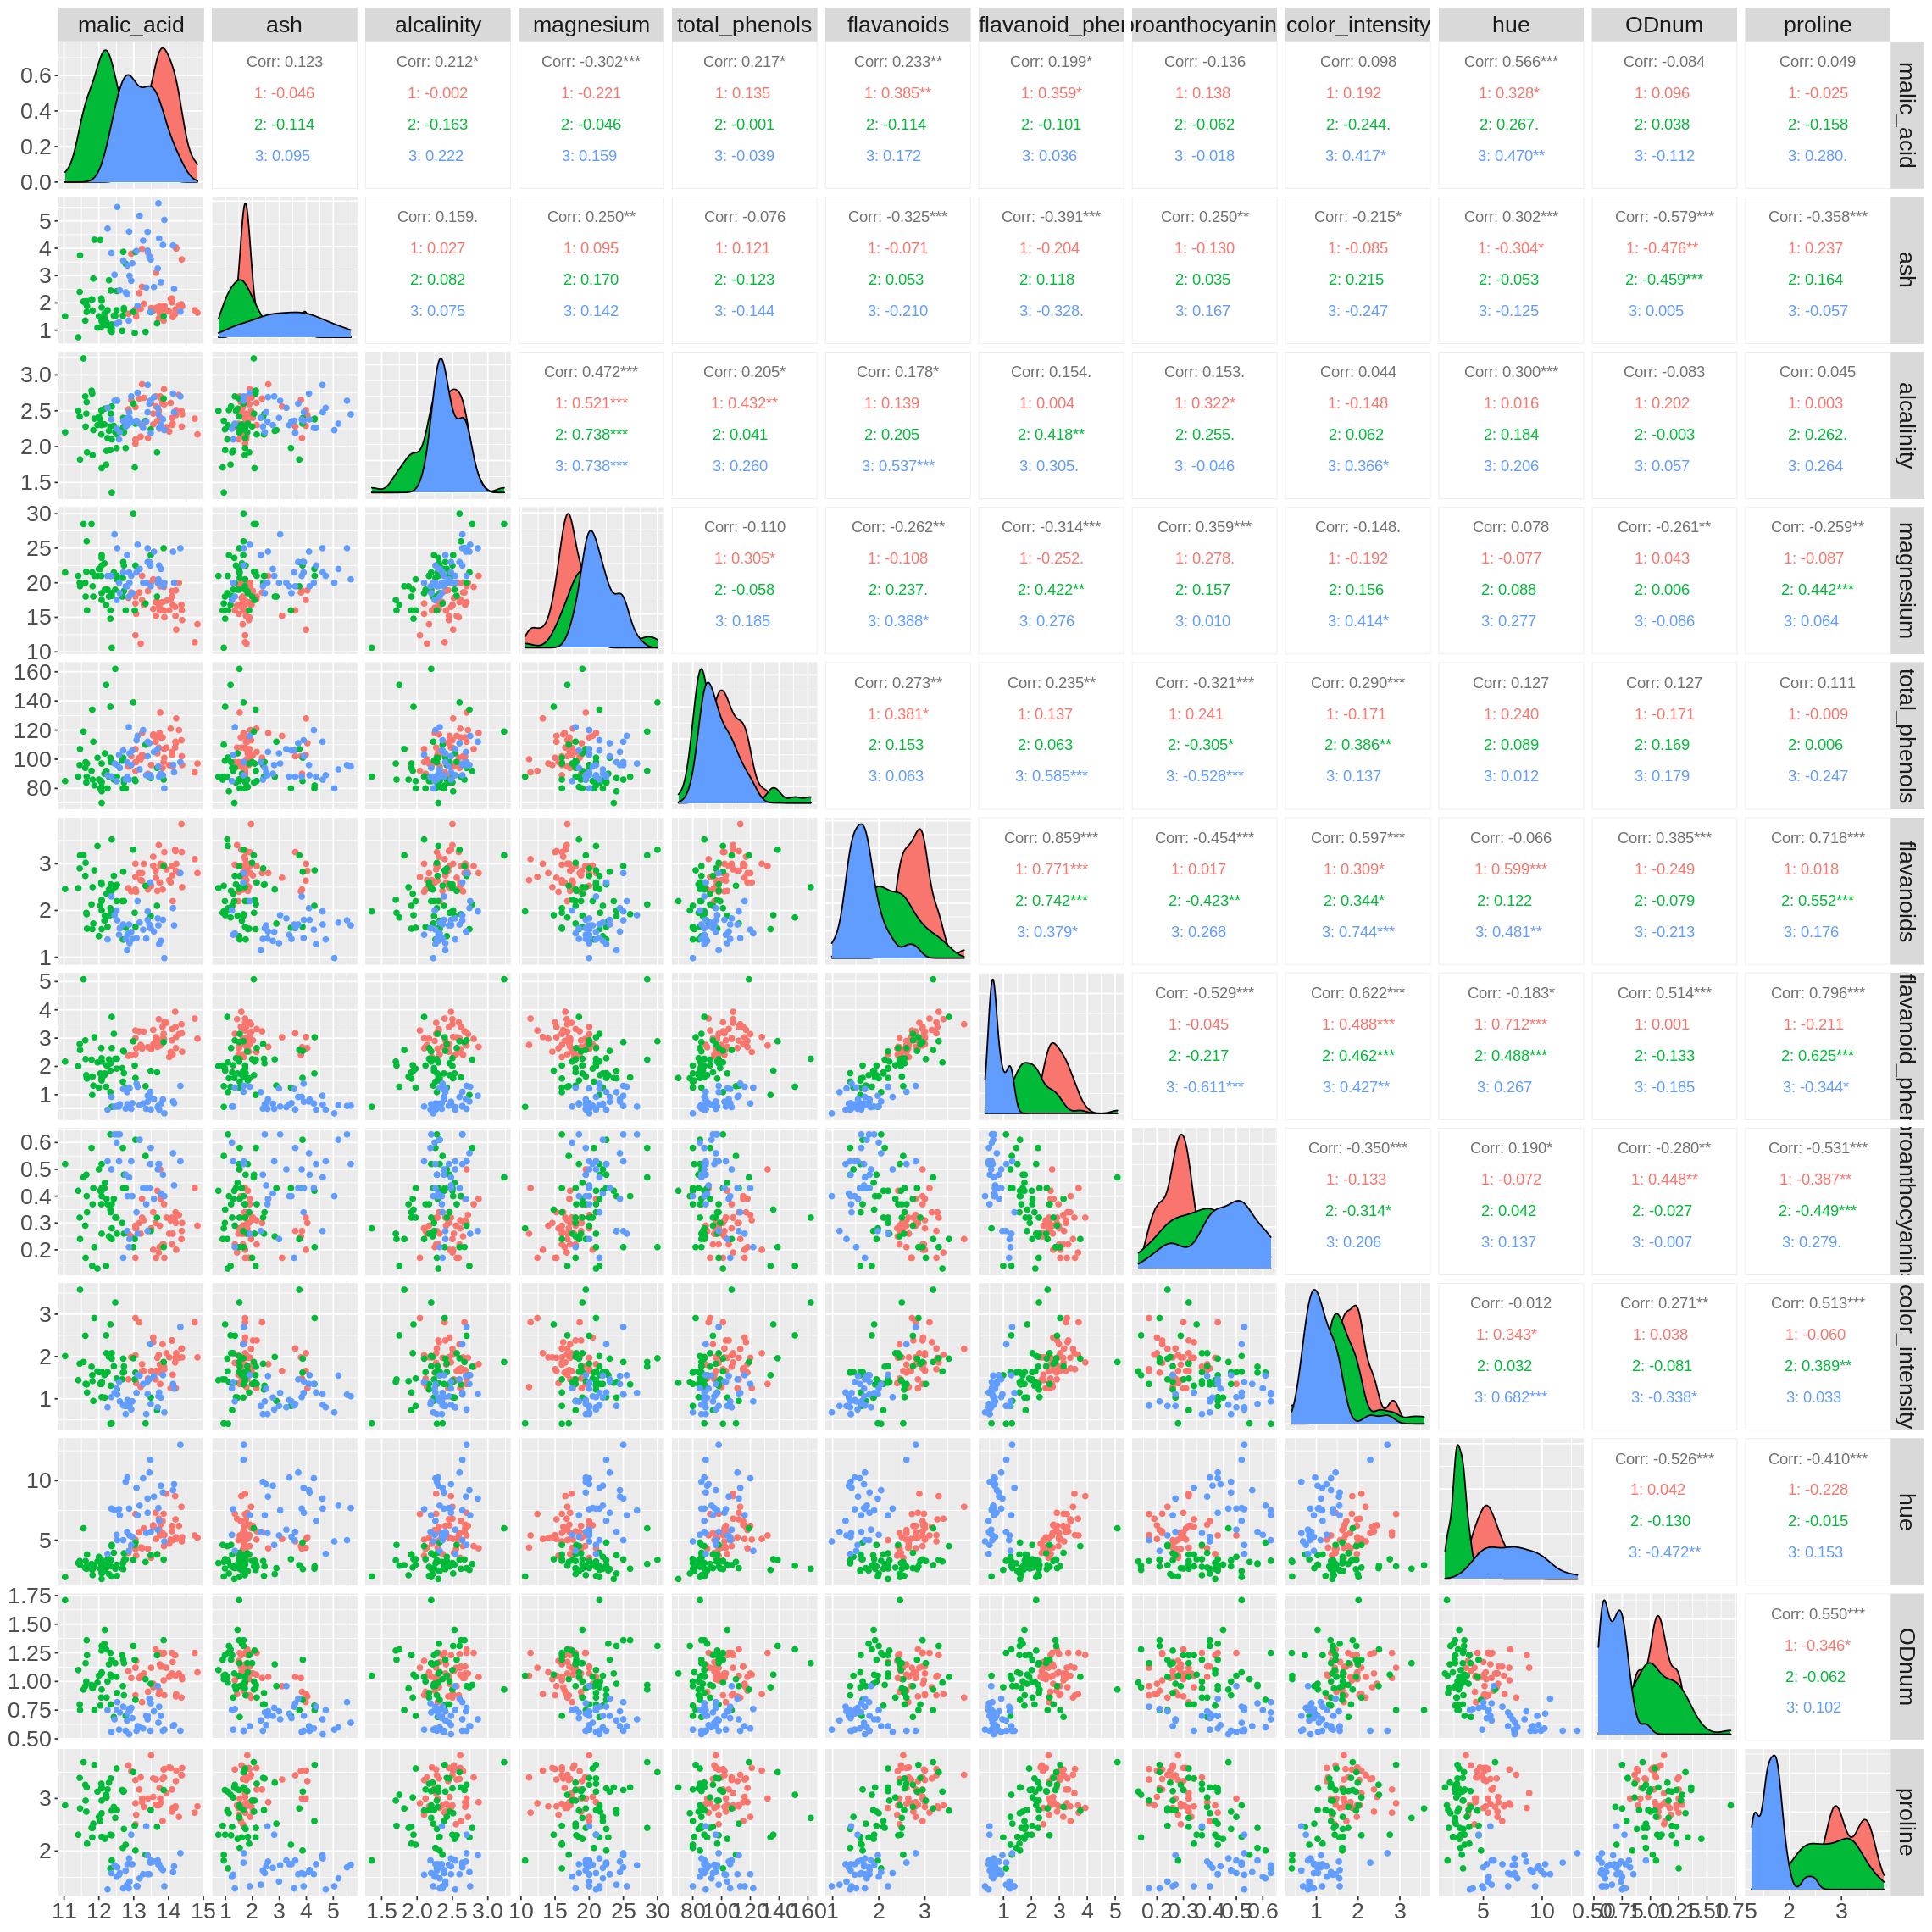

In [13]:
# scatter plots of the variables
options(repr.plot.width = 19, repr.plot.height = 19)
wine_training_data |> 
  ggpairs(columns = 2:13, ggplot2::aes(colour = alcohol))+
    theme(text = element_text(size = 20))#, upper = list(continuous = "density", combo = "box_no_facet")

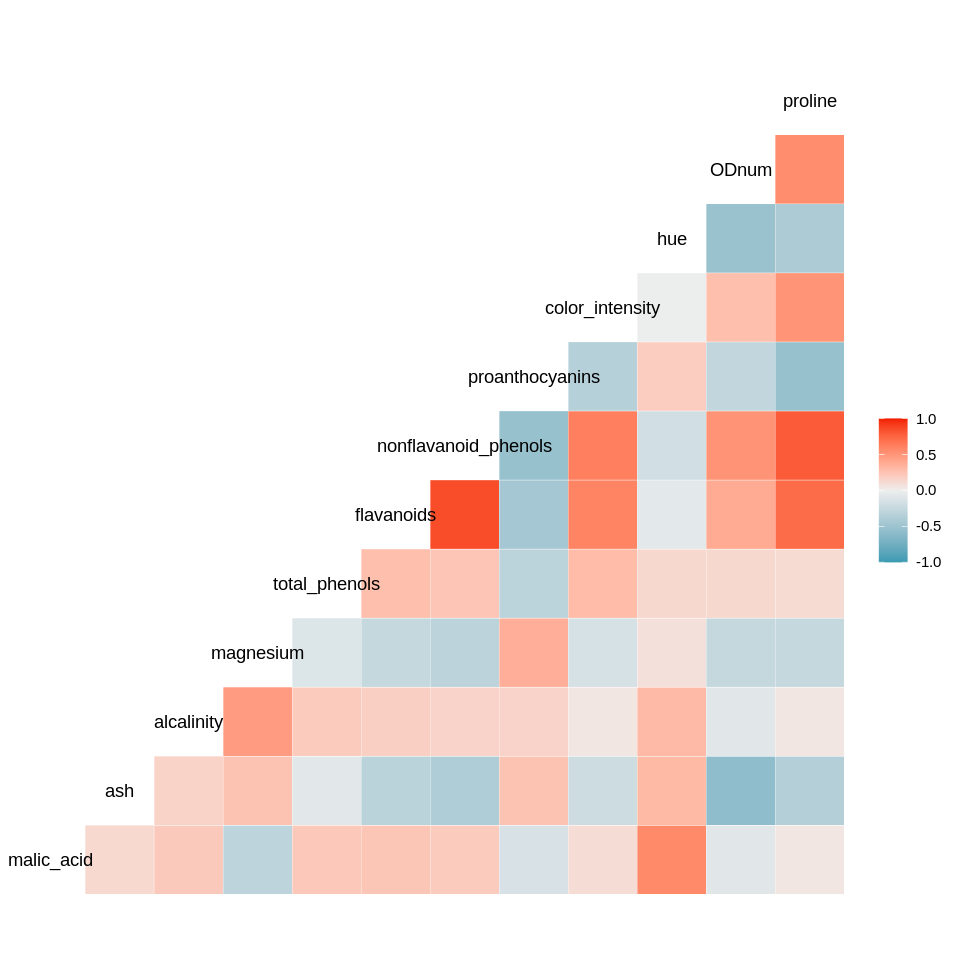

In [14]:
# correlation plot 
options(repr.plot.width = 8, repr.plot.height = 8)
corr_plot <- wine_training_data |>
    select(-alcohol) |>
    ggcorr() +
        theme(text = element_text(size = 20))
corr_plot

### Methods
A classification model will be used, since the cultivator can only be one of three things. Though there are numerous variables, only two will be chosen, as not all are useful for prediction. 

By looking at the visualization, pairs of variables can be identified as strong candidates for analysis. Examples are the plots of “Malic acid versus Proline” and “Non Flavonoid Phenols versus Hue”. Wines from each region are separated into relatively clear areas in the plot. 

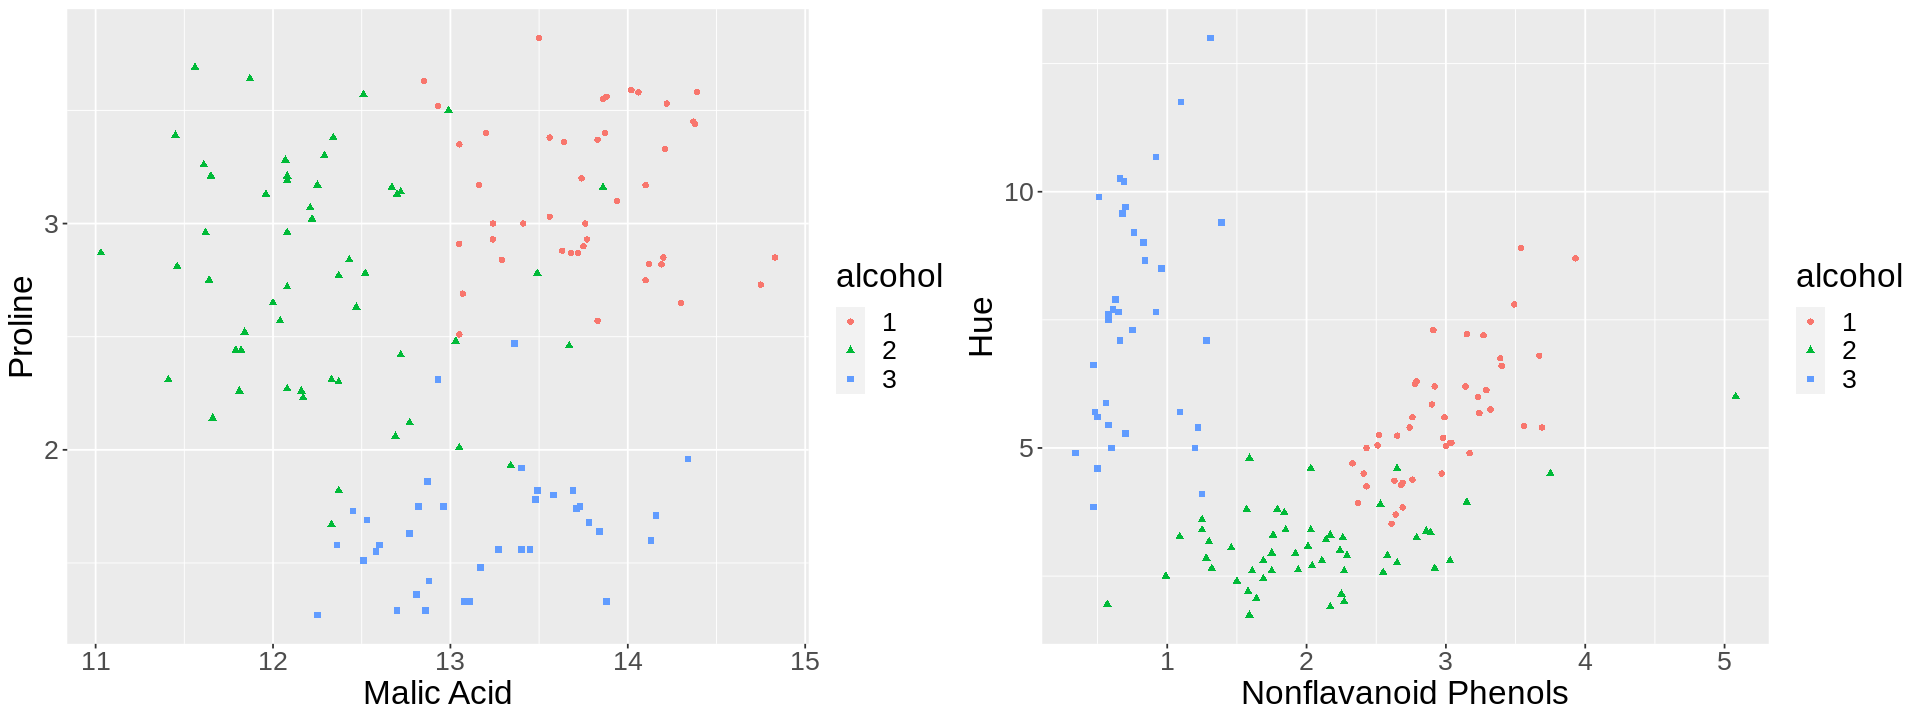

In [15]:
options(repr.plot.width = 16, repr.plot.height = 6)
malic_acid_proline_plot <- wine_training_data |>
    ggplot(aes(x = malic_acid, y = proline, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline") + 
    theme(text = element_text(size = 20))


nonflavanoid_hue_plot <- wine_training_data |>
    ggplot(aes(x = nonflavanoid_phenols, y = hue, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Nonflavanoid Phenols", y = "Hue") + 
    theme(text = element_text(size = 20))


plot_of_options <- plot_grid(malic_acid_proline_plot, nonflavanoid_hue_plot, ncol = 2)
plot_of_options

A bad example is Alkalinity versus Magnesium. Wines from all the regions are overlapped and closely grouped together, making them indistinguishable.

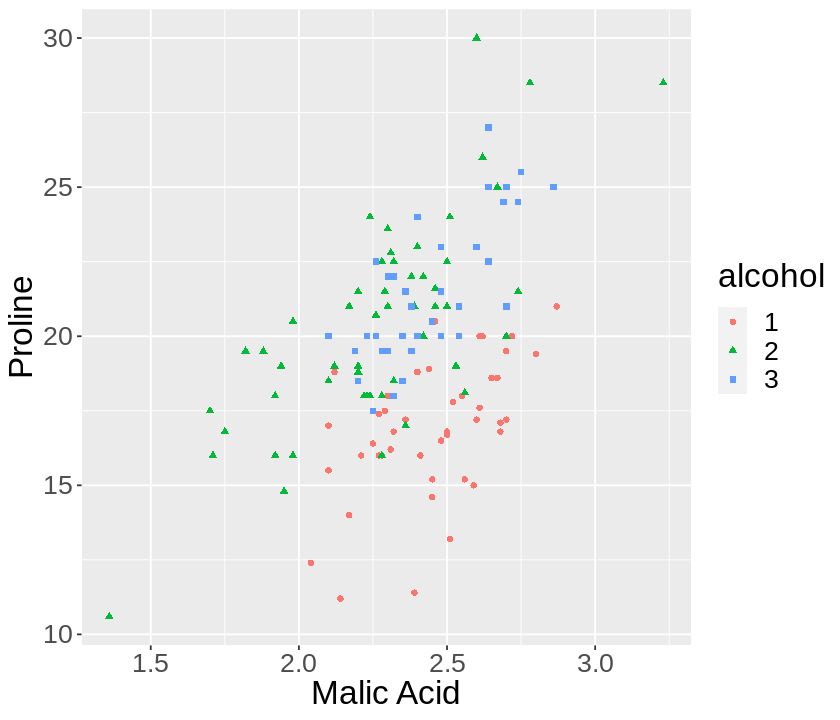

In [16]:
options(repr.plot.width = 7, repr.plot.height = 6)
alcalinity_magnesium_plot <- wine_training_data |>
    ggplot(aes(x = alcalinity, y = magnesium, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline") + 
    theme(text = element_text(size = 20))
alcalinity_magnesium_plot

While scaling and centering have not been performed yet, this provides a starting point. The choice is subjective, and others may make different choices. Nonetheless, the model will use the following to predict alcohol origin: Hue and Non Flavonoid Phenols. A more rigorous method of choosing the variables may be explored in a future project. 
### Visualization
One way to visualize the results is a scatter plot. Since 2 variables are chosen, results can be easily visualized on a 2D plot. This allows the testing data to be highlighted, allowing for readers to visually see the "goodness" of the model. Areas of the graph where the model will predict what region a wine is from can also be colored. 

### Expectations

Just by looking at the visualization, there are distinct areas where each wine group dominates. This is a good indicator that the model should be able to predict where the wine originates from based on these variables. However, there is some overlapping of the points, which can make it difficult for the model to accurately classify edge cases. Nevertheless, it is expected that this choice of variables will be a good predictor of the data's wine origin. 

Such findings may allow for wineries to selectively choose wines from certain regions based on their chemical composition. Wines from certain regions, such as Napa Valley, or types of grapes, such as Cabernet Sauvignon, may have a distinct chemical composition that makes their flavor popular and desirable. The findings of this model could allow for wineries to alter the chemical composition of cheaper wines to match those from more expensive regions.

This leads to the natural question of where these chemicals come from, and what makes the wines from these regions have varying levels of these chemicals - a topic for future investigation.
